In [20]:
!pip install python-chess


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
import chess
import chess.engine
import random
import numpy


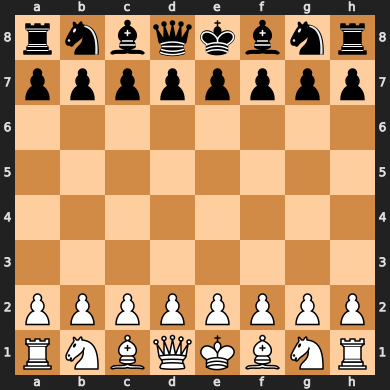

In [22]:
board = chess.Board()
board

In [23]:
print(chess.PIECE_TYPES)
for piece in  chess.PIECE_TYPES:
  print(piece)

range(1, 7)
1
2
3
4
5
6


In [24]:
squares_index = {
  'a': 0,
  'b': 1,
  'c': 2,
  'd': 3,
  'e': 4,
  'f': 5,
  'g': 6,
  'h': 7
}

def square_to_index(square):
  letter=chess.square_name(square)
  return 8-int(letter[1]),squares_index[letter[0]]

def split_dims(board):
  board3d = numpy.zeros((14,8,8),dtype=numpy.int8)
  for piece in  chess.PIECE_TYPES:
    for square in board.pieces(piece,chess.WHITE):
      idx = numpy.unravel_index(square,(8,8))
      board3d[piece-1][7-idx[0]][idx[1]]=1 
    for square in board.pieces(piece,chess.BLACK):
      idx = numpy.unravel_index(square,(8,8))
      board3d[piece+5][7-idx[0]][idx[1]]=1 

  aux = board.turn 
  board.turn = chess.WHITE
  for move in board.legal_moves: 
    i,j = square_to_index(move.to_square)
    board3d[12][i][j]=1 
  board.turn=chess.BLACK 

  for move in board.legal_moves:
    i,j = square_to_index(move.to_square)
    board3d[13][i][j]=1
  board.turn = aux 

  return board3d

In [25]:
split_dims(board)

array([[[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 1, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        

In [26]:
import tensorflow.keras.models as models 
import tensorflow.keras.layers as layers 
import tensorflow.keras.utils as utils 
import tensorflow.keras.optimizers as optimizers 

In [27]:
def build_model(conv_size,conv_depth):
  board3d = layers.Input(shape=(14,8,8))

  x=board3d
  for _ in range(conv_depth):
    x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same', activation='relu', data_format='channels_first')(x)
  x=layers.Flatten()(x) 
  x=layers.Dense(64,'relu')(x) 
  x=layers.Dense(1,'sigmoid')(x) 

  return models.Model(inputs=board3d,outputs=x)

In [28]:
def build_model_residual(conv_size, conv_depth):
  board3d = layers.Input(shape=(14, 8, 8))

  # adding the convolutional layers
  x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same', data_format='channels_first')(board3d)
  for _ in range(conv_depth):
    previous = x
    x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same', data_format='channels_first')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same', data_format='channels_first')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, previous])
    x = layers.Activation('relu')(x)
  x = layers.Flatten()(x)
  x = layers.Dense(1, 'sigmoid')(x)

  return models.Model(inputs=board3d, outputs=x)

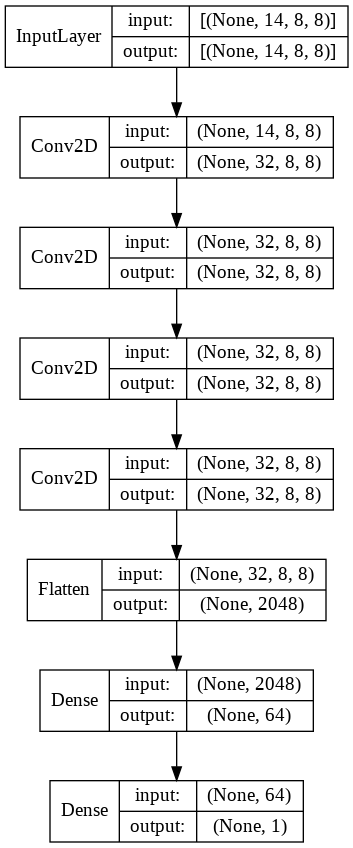

In [29]:
model=build_model(32,4)
utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False)

In [30]:
import tensorflow.keras.callbacks as callbacks 

def get_dataset():
	container = numpy.load('/content/drive/MyDrive/Colab Notebooks/dataset.npz')
	b, v = container['b'], container['v']
	v = numpy.asarray(v / abs(v).max() / 2 + 0.5, dtype=numpy.float32) # normalization (0 - 1)
	return b, v


x_train, y_train = get_dataset()
print(x_train.shape)
print(y_train.shape)

(1500000, 14, 8, 8)
(1500000,)


In [31]:
!pip install tensorflow==2.7

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
model.compile(optimizer=optimizers.Adam(5e-4), loss='mean_squared_error')
model.summary()

print(x_train.shape)
model.fit(
          x_train,
          y_train ,
          batch_size=2048,
          epochs=1000,
          verbose=1,
          validation_split=0.1,
          callbacks=[callbacks.ReduceLROnPlateau(monitor='loss', patience=10),
                     callbacks.EarlyStopping(monitor='loss', patience=15, min_delta=1e-4)]
          )

model.save('model.h5')

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 8, 8)]        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 8, 8)          4064      
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 8, 8)          9248      
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 8, 8)          9248      
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 8, 8)          9248      
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 64)                1311

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  if getattr(self, 'test_function', None) is None or has_recompiled:


1350000/1350000 [==============================] - 16s 12us/sample - loss: 0.0011 - val_loss: 6.5775e-04 - lr: 5.0000e-04
Epoch 2/1000
1350000/1350000 [==============================] - 18s 13us/sample - loss: 5.6162e-04 - val_loss: 4.9784e-04 - lr: 5.0000e-04
Epoch 3/1000
1350000/1350000 [==============================] - 16s 12us/sample - loss: 4.6900e-04 - val_loss: 4.6440e-04 - lr: 5.0000e-04
Epoch 4/1000
1350000/1350000 [==============================] - 17s 13us/sample - loss: 4.2025e-04 - val_loss: 4.1233e-04 - lr: 5.0000e-04
Epoch 5/1000
1350000/1350000 [==============================] - 15s 11us/sample - loss: 3.9210e-04 - val_loss: 3.9626e-04 - lr: 5.0000e-04
Epoch 6/1000
1350000/1350000 [==============================] - 16s 12us/sample - loss: 3.6839e-04 - val_loss: 4.6269e-04 - lr: 5.0000e-04
Epoch 7/1000
1350000/1350000 [==============================] - 15s 11us/sample - loss: 3.5095e-04 - val_loss: 3.6262e-04 - lr: 5.0000e-04
Epoch 8/1000
1350000/1350000 [==============

In [33]:
print(x_train[0].shape)
print(model.predict(x_train))

(14, 8, 8)


/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  def _make_predict_function(self):


[[0.21939601]
 [0.21942018]
 [0.1731582 ]
 ...
 [0.49945474]
 [0.51554304]
 [0.53728914]]


In [34]:
y_train

array([0.23126382, 0.21182439, 0.18173599, ..., 0.49462527, 0.5198915 ,
       0.5300382 ], dtype=float32)

In [35]:
!pip install keras-rl2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [36]:
def minimaxevaluation(board):
  board3d = split_dims(board)
  board3d = numpy.expand_dims(board3d,0) 
  return model.predict(board3d)[0][0]

def minimax(board,depth,alpha,beta,flag):
  if depth==0 or board.is_game_over():
    return minimaxevaluation(board)
  if flag: 
    max_eval = -1000000
    for move in board.legal_moves:
      board.push(move)
      eval = minimax(board, depth - 1, alpha, beta, False)
      board.pop() 
      max_eval = max(max_eval,eval)
      alpha=max(alpha,eval)
      if beta<=alpha:
        break 
    return max_eval 
  else:
    min_eval=1000000
    for move in board.legal_moves:
      board.push(move)
      eval = minimax(board, depth - 1, alpha, beta, True)
      board.pop() 
      min_eval = min(min_eval,eval)
      beta=max(beta,eval)
      if beta<=alpha:
        break 
    return min_eval 

def ai_move(board,depth):
  max_move=None 
  max_eval= -1000000
  for move in board.legal_moves:
    board.push(move)
    eval = minimax(board, depth - 1, -1000000, 1000000, False)
    board.pop()
    if eval > max_eval:
      max_eval = eval
      max_move = move
  
  return max_move


In [43]:
board=chess.Board() 
while True:
  move = ai_move(board, 1)
  board.push(move)
  print(move)
  print(f'\n{board}')
  if board.is_game_over():
    break
  move=input('Enter the move:')
  board.push_san(move)
  print(f'\n{board}')
  if board.is_game_over():
    break

e2e3

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . P . . .
P P P P . P P P
R N B Q K B N R
Enter the move:d5

r n b q k b n r
p p p . p p p p
. . . . . . . .
. . . p . . . .
. . . . . . . .
. . . . P . . .
P P P P . P P P
R N B Q K B N R
f1b5

r n b q k b n r
p p p . p p p p
. . . . . . . .
. B . p . . . .
. . . . . . . .
. . . . P . . .
P P P P . P P P
R N B Q K . N R
Enter the move:c6

r n b q k b n r
p p . . p p p p
. . p . . . . .
. B . p . . . .
. . . . . . . .
. . . . P . . .
P P P P . P P P
R N B Q K . N R
b5c6

r n b q k b n r
p p . . p p p p
. . B . . . . .
. . . p . . . .
. . . . . . . .
. . . . P . . .
P P P P . P P P
R N B Q K . N R
Enter the move:Nc6

r . b q k b n r
p p . . p p p p
. . n . . . . .
. . . p . . . .
. . . . . . . .
. . . . P . . .
P P P P . P P P
R N B Q K . N R
b1c3

r . b q k b n r
p p . . p p p p
. . n . . . . .
. . . p . . . .
. . . . . . . .
. . N . P . . .
P P P P . P P P
R . B Q K . N R
Enter the move:d4

r .

KeyboardInterrupt: ignored